# Time Series Forecasting (Continued)
**Project**: M5 Project 5
**Author**: Jacob Buysse

In this project we will be performing regression modeling on flights from the New York area and adding complimentary data to see how it improves perfromance.

In this notebook we will be using...

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib as plt
import seaborn as sns
import scipy
import scipy.sparse as sp
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, SGDRegressor, PoissonRegressor
from sklearn.ensemble import RandomForestRegressor

We will configure our plots for readable labels, high resolution, and automatic layout.

In [2]:
plt.rc("axes", labelsize=18)
plt.rc("figure", dpi=150, autolayout=True)

We will define a helper function for scoring different models.

In [3]:
def score_model(actual, predicted):
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(actual, predicted)
    print(f"RMSE (Count): {rmse:,.0f}, MAPE: {mape:.1%}")

## Part II

We will load our cleaned dataset and split it into a train/test set keeping the last year out for the testing set.

In [4]:
df = pd.read_feather('./counts.feather')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1826 entries, 0 to 1825
Columns: 139 entries, date to holiday_Western Easter -3
dtypes: bool(128), category(2), datetime64[ns](1), int64(8)
memory usage: 361.1 KB


Let us add a days since first date (`day_serial`).

In [5]:
first_date = datetime.datetime(year=2013, month=1, day=1)
last_date = datetime.datetime(year=2017, month=12, day=31)
df['day_serial'] = df.date.apply(lambda value: (value - first_date).days + 1)

Now let us split it into a training and test dataset (keeping the entire year 2017 for the testing set).

In [6]:
test_mask = df.year == 2017
train_df = df[~test_mask]
test_df = df[test_mask]
print(f"Training size: {train_df.shape}, Testing size: {test_df.shape}")

Training size: (1461, 140), Testing size: (365, 140)


Linear Regression: r = -0.23832437454041616, p = 2.5812714220214682e-20, se = 0.006014670625694982


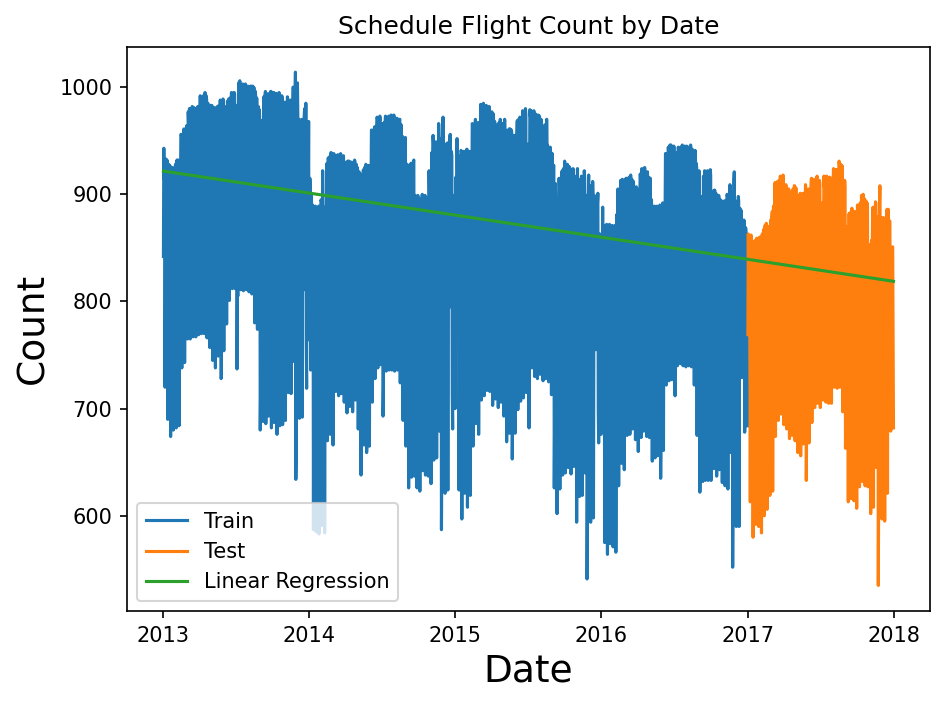

In [7]:
plot = sns.lineplot(train_df, x='date', y='count', label='Train')
sns.lineplot(test_df, x='date', y='count', label='Test')
slope, intercept, r, p, se = scipy.stats.linregress(train_df.day_serial, train_df['count'])
print(f"Linear Regression: r = {r}, p = {p}, se = {se}")
sns.lineplot(x=[first_date, last_date], y=[slope + intercept, slope * len(df) + intercept], label='Linear Regression')
plot.set(title='Schedule Flight Count by Date', xlabel='Date', ylabel='Count');
plot.figure.savefig('lr.png')

So there does appear to be a significant negative correlation between the date and the count.

In [8]:
print(f"Starting from {intercept} and decreasing by {-slope * 365} each year.")

Starting from 921.7485621595267 and decreasing by 20.577782958845162 each year.


## Part III

We will now model our data using Ridge regression with L2 regularization.  First we need to prepare our categorical data for training and scale our numeric data.

In [9]:
hot_enc = OneHotEncoder()
cat_features = ["month", "weekday"]
hot_enc.fit(train_df[cat_features])
train_hot = hot_enc.transform(train_df[cat_features])
test_hot = hot_enc.transform(test_df[cat_features])

Now we will scale our numeric features.

In [10]:
scaler = StandardScaler()
num_features = ["year", "doy", "PRCP", "SNOW", "SNWD", "TMAX", "TMIN", "day_serial"]
scaler.fit(train_df[num_features])
train_num = scaler.transform(train_df[num_features])
test_num = scaler.transform(test_df[num_features])

Next we will collect our boolean features.

In [11]:
bool_features = ["weekend", "leapday"] + df.columns[df.columns.str.contains("holiday_")].values.tolist()
train_bool = train_df[bool_features]
test_bool = test_df[bool_features]

And finally we combined all of the datasets into X,y for train and test.

In [12]:
train_X = sp.hstack((train_hot, train_num, train_bool))
train_y = train_df['count'].values
test_X = sp.hstack((test_hot, test_num, test_bool))
test_y = test_df['count'].values
print(f"Train X {train_X.shape}, y {len(train_y)}")
print(f"Test X {test_X.shape}, y {len(test_y)}")

Train X (1461, 155), y 1461
Test X (365, 155), y 365


Let us now do a Ridge regression.

In [13]:
model = Ridge(random_state=777, positive=True)
model.fit(train_X, train_y)
pred_y = model.predict(test_X)
score_model(test_y, pred_y)

RMSE (Count): 60, MAPE: 6.2%


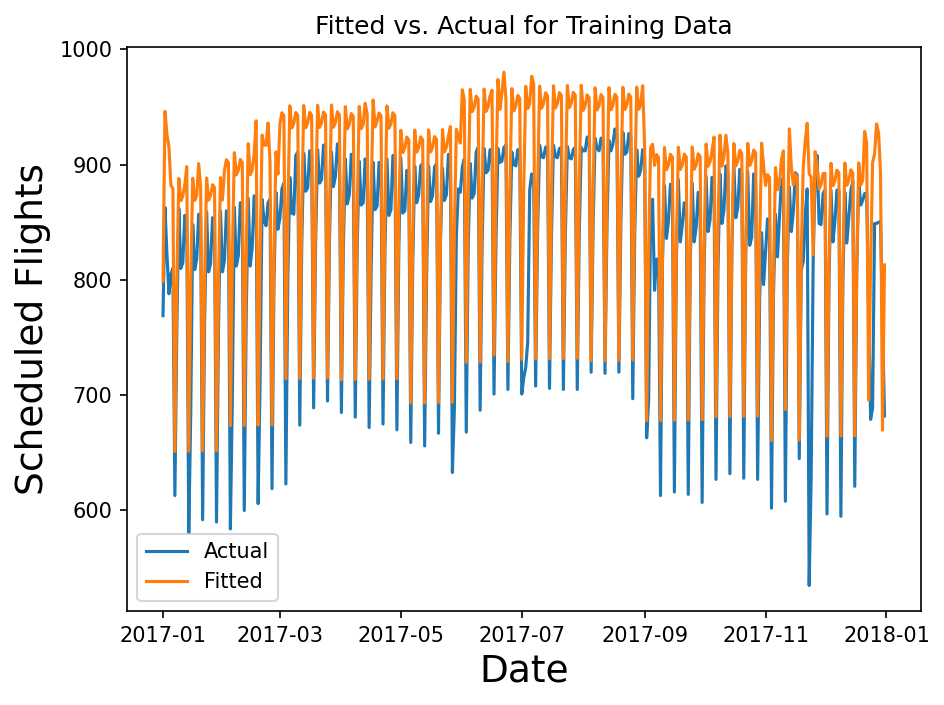

In [14]:
plot = sns.lineplot(x=test_df.date, y=test_y, label='Actual')
sns.lineplot(x=test_df.date, y=pred_y, label='Fitted')
plot.set(title='Fitted vs. Actual for Training Data', xlabel='Date', ylabel='Scheduled Flights');

Now let us compute the residuals and plot them.

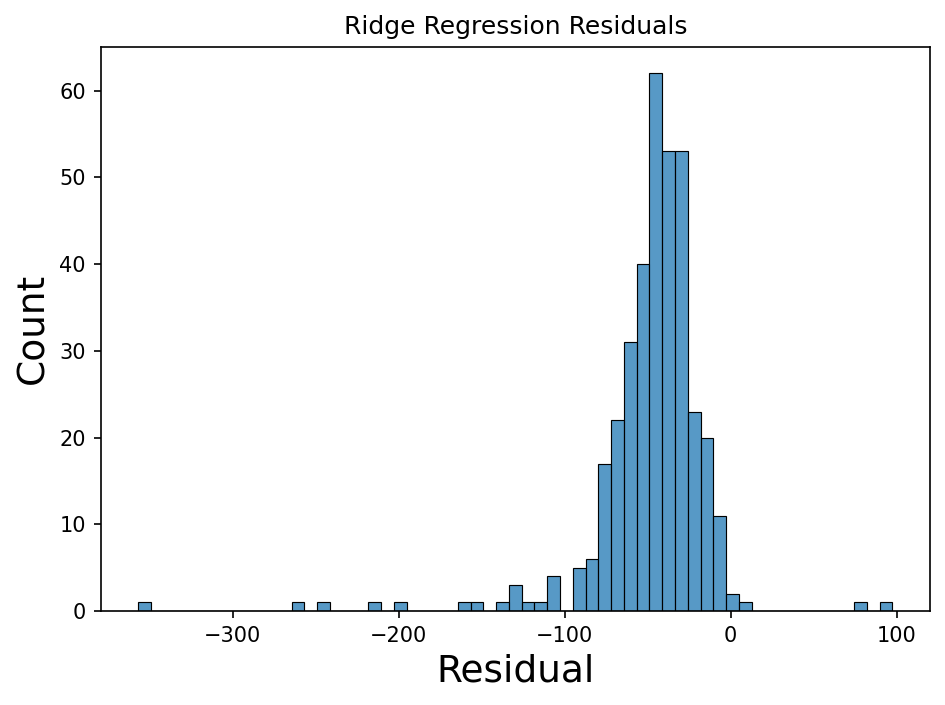

In [15]:
residuals = test_y - pred_y
plot = sns.histplot(residuals)
plot.set(title='Ridge Regression Residuals', xlabel='Residual');

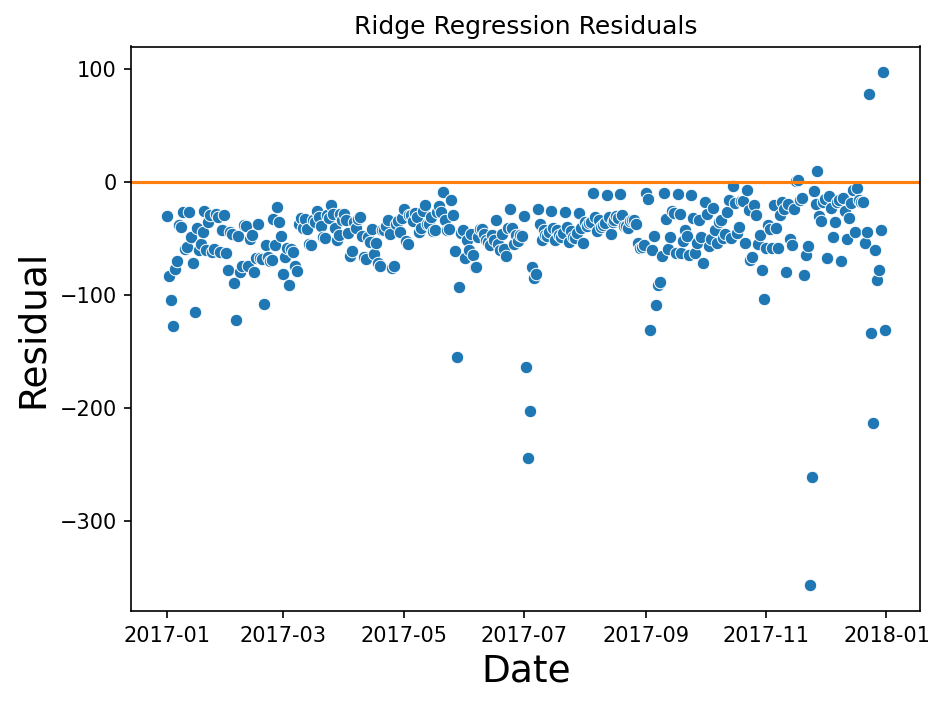

In [16]:
plot = sns.scatterplot(x=test_df.date, y=residuals)
plt.pyplot.axhline(y=0, color="tab:orange")
plot.set(title="Ridge Regression Residuals", xlabel="Date", ylabel="Residual");

We can see from these graphs that we are estimating too high when we are incorrect and almost never underestimating.  We can also see from the scatter plot that there are specific dates where the residual is much larger indicating that we may not be handling all of the seasonal dates correctly.

Per the instructions, we were to use the `postiive=True` attribute for the Ridge regression to prevent from estimate negative counts.  However, let us look at what our model and residuals look like without that property.

In [17]:
lin_model = Ridge(random_state=777)
lin_model.fit(train_X, train_y)
pred_y = lin_model.predict(test_X)
score_model(test_y, pred_y)

RMSE (Count): 25, MAPE: 2.1%


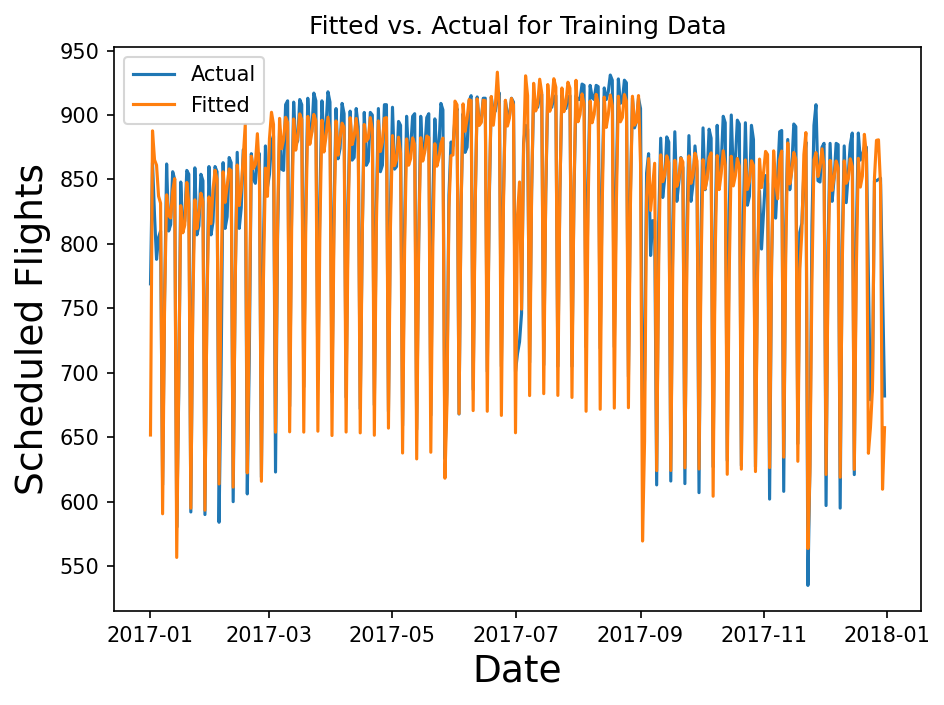

In [18]:
plot = sns.lineplot(x=test_df.date, y=test_y, label='Actual')
sns.lineplot(x=test_df.date, y=pred_y, label='Fitted')
plot.set(title='Fitted vs. Actual for Training Data', xlabel='Date', ylabel='Scheduled Flights');
plot.figure.savefig('actual_vs_fitted.png')

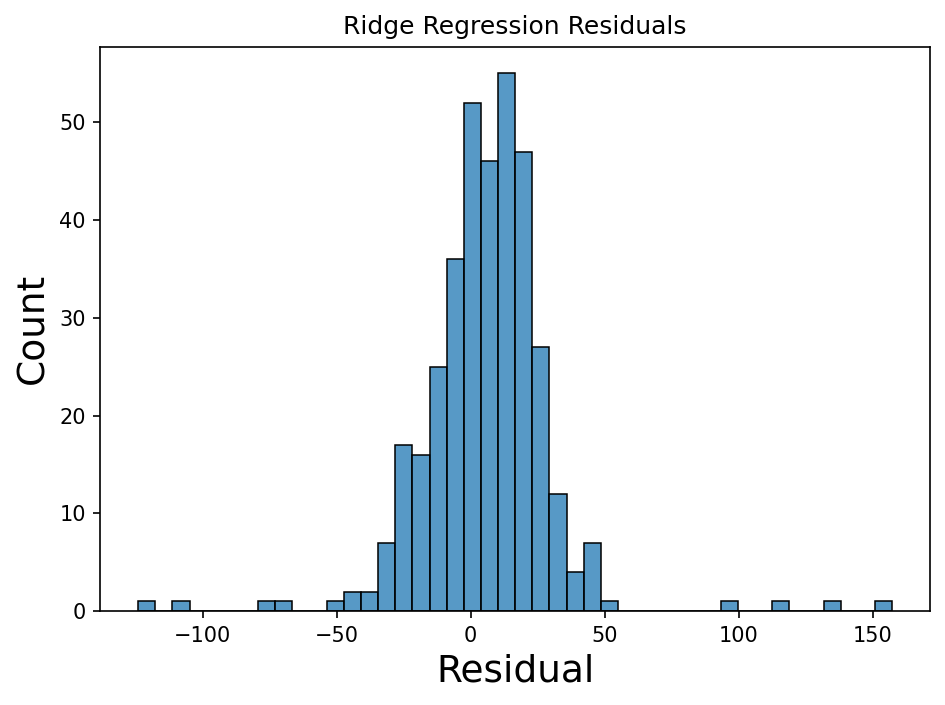

In [19]:
residuals = test_y - pred_y
plot = sns.histplot(residuals)
plot.set(title='Ridge Regression Residuals', xlabel='Residual');
plot.figure.savefig('residual_histogram.png')

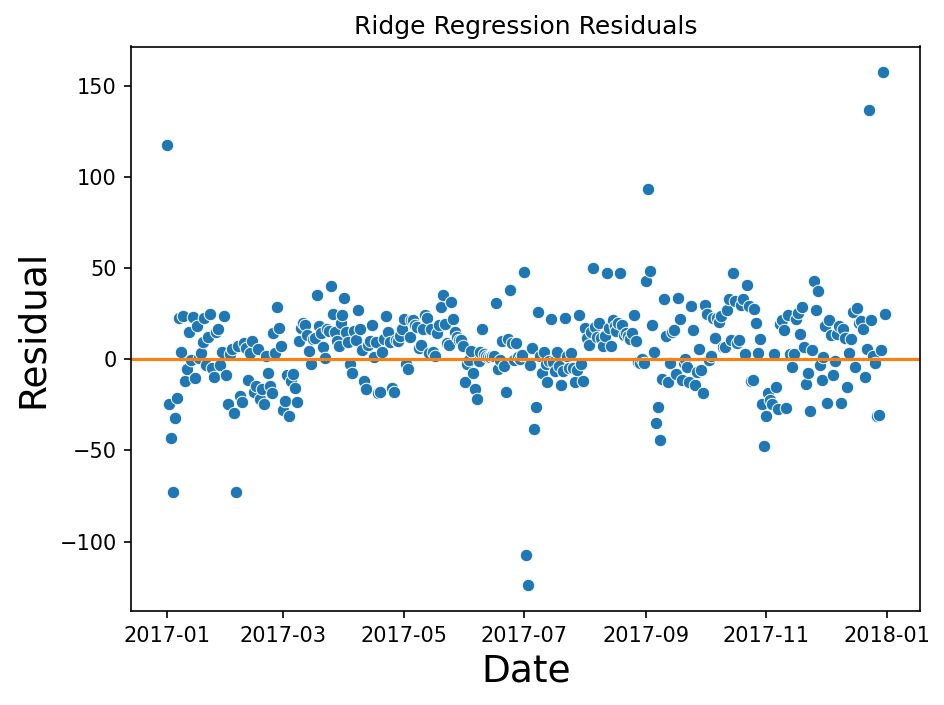

In [20]:
plot = sns.scatterplot(x=test_df.date, y=residuals)
plt.pyplot.axhline(y=0, color="tab:orange")
plot.set(title="Ridge Regression Residuals", xlabel="Date", ylabel="Residual");
plot.figure.savefig('residual_scatter.png')

We see that our RMSE is better (25 vs. 60) and our MAPE is also better (2.1% vs. 6.2%).  The graph of fitted vs. actual is better (peaks and troughs line up better) and our residuals appear to be centered around 0.  Since we didn't actually end up predicting negative values, I think that specifying the positive attribute for the Ridge regression may have been a incorrect premature optimization.

However, we still see several outliers in the +/- 100 count region (outside the normal distribution).  These appear to be located around the 4th of July, Christmas, New Years.  We included engineered features for 3 days before and after each holiday, but perhaps more careful analysis of specific days of the week before or after might be worth considering.

Now let us try some different models.  We will start by using a Poisson regressor.

In [21]:
model = PoissonRegressor(max_iter=10000)
model.fit(train_X, train_y)
pred_y = model.predict(test_X)
score_model(test_y, pred_y)

RMSE (Count): 25, MAPE: 2.2%


The results are very similar to the Linear regressor (without the positive attribute).  Now let us try the SGD regressor.

In [22]:
model = SGDRegressor(random_state=777)
model.fit(train_X, train_y)
pred_y = model.predict(test_X)
score_model(test_y, pred_y)

RMSE (Count): 25, MAPE: 2.2%


SGD behaved pretty much identially to the Poisson regressor.

Now let us try a Random Forest regressor.

In [23]:
rf_model = RandomForestRegressor(max_depth=15, random_state=777)
rf_model.fit(train_X, train_y)
pred_y = rf_model.predict(test_X)
score_model(test_y, pred_y)

RMSE (Count): 28, MAPE: 2.3%


This gives a pretty good result but is still slightly worse than both Linear and Poisson.

Now let us compare the largest coefficients in the linear model with the most important features in the random forest

In [24]:
all_features = cat_features + num_features + bool_features
top_pos_lin_features = sorted(range(len(lin_model.coef_)), key = lambda index: lin_model.coef_[index])[-10:]
top_neg_lin_features = sorted(range(len(lin_model.coef_)), key = lambda index: -lin_model.coef_[index])[-10:]
print("Top 10 Positive Features:")
print(*list(map(lambda index: f"{all_features[index]} = {lin_model.coef_[index]}", top_pos_lin_features)), sep="\n")
print("")
print("Top 10 Negative Features:")
print(*list(map(lambda index: f"{all_features[index]} = {lin_model.coef_[index]}", top_neg_lin_features)), sep="\n")

Top 10 Positive Features:
holiday_Thanksgiving Eve -2 = 27.043457869380813
holiday_4th of July +3 = 27.310587072164573
SNOW = 29.594045395280382
TMAX = 29.925661690935872
holiday_4th of July -3 = 33.326757574094366
holiday_Thanksgiving Day -3 = 37.112139724610806
SNWD = 41.348376189054235
holiday_Valentine’s Day -2 = 70.40402319800273
holiday_Veterans Day -3 = 70.40402319800273
holiday_Valentine’s Day -3 = 78.01122961438028

Top 10 Negative Features:
holiday_Columbus Day +3 = -89.1197676860697
holiday_Eastern Easter -1 = -89.1197676860697
holiday_Christmas Eve +1 = -91.46396022317754
holiday_Valentine’s Day -1 = -122.56799484799679
holiday_Veterans Day -2 = -122.56799484799679
holiday_Thanksgiving Day = -123.04438696020134
holiday_4th of July -2 = -124.79071779737463
holiday_Valentine’s Day +3 = -154.41706578973165
holiday_Veterans Day -1 = -154.41706578973165
holiday_Christmas Eve +3 = -154.49121566754494


In [25]:
top_rf_features = sorted(range(len(rf_model.feature_importances_)), key = lambda index: rf_model.feature_importances_[index])[-10:]
print("Top 10 Random Forest Features")
print(*list(map(lambda index: all_features[index], top_rf_features)), sep="\n")

Top 10 Random Forest Features
holiday_Christmas Eve +3
holiday_Christmas Day -2
holiday_Christmas Day -3
holiday_Valentine’s Day +3
holiday_Veterans Day -1
holiday_Christmas Eve +1
holiday_4th of July -3
holiday_Christmas Day +1
holiday_Christmas Eve
holiday_4th of July -2


The features are very similar.  The week of Christmas, the days before the 4th of July, Valentine's day, and Veterans day (and the surrounding days) show up in both models.